# Classification

This notebook is heavily inspired by Andre Guernon work, that can be found here: https://github.com/ageron/handson-ml/blob/master/04_training_linear_models.ipynb

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from time import time

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## The MNIST Dataset

We will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
mnist['DESCR']

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

Let's import the dataset, inputs and labels:

In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
X.shape, y.shape

((70000, 784), (70000,))

`X` contains 70,000 images each of them contains 784 features, because each of them is a 28x28 picture. Each feature is a pixel intensity encoded in an 8-bit scale: from 0 (white) to 255 (black)

Let's display one or more images using matplotlib `imshow()`

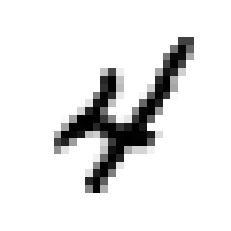

In [6]:
digit = X[9]
digit_img = digit.reshape(28, 28)

plt.imshow(digit_img, cmap='binary')
plt.axis('off')
plt.show()

In [7]:
y[9]

'4'

The label is a string. We must convert it to a number for it to work on a Machine Learning algorithm.

In [8]:
y = y.astype(np.uint8)

In [9]:
def show_digits(instances, images_per_row=10, **opts):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **opts)
    plt.axis("off")

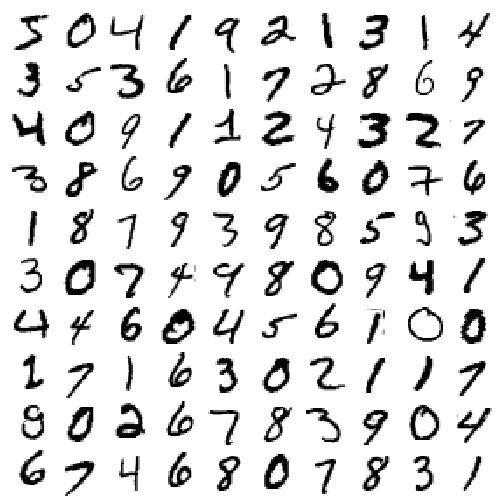

In [10]:
plt.figure(figsize=(9,9))
example_images = X[:100]
show_digits(example_images, images_per_row=10)
plt.show()

## 4.1 Split the dataset in training and test set

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

## 4.1 Training a binary classifier

**Exercise 1**: Let's define two set of labels for the training and test set, named `y_train_8` and `y_test_8`. These must contain the value `True` whenever the original label is an 8, `False` otherwise

In [13]:
# Write your solution here:
y_train_8 = np.array([True if target == 8 else False for target in y_train ])

In [14]:
y_train_8 = (y_train==8)
y_test_8 = (y_test==8)

In [15]:
y_train_8[:20], y_train[:20]

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True,
        False, False]),
 array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9],
       dtype=uint8))

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_cl = SGDClassifier(random_state=77)
sgd_cl.fit(X_train, y_train_8)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=77, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
sgd_cl.predict(X_train[10:20])

array([False,  True, False, False, False, False, False,  True, False,
       False])

### 4.1.1 Performance Measures: measuring Accuracy Using Cross-Validation

Sometimes you need more control over cross-validation than what is offered out of the box with `cross_val_score()`. In this example we are going to use the `StratifiedKFold` class to implement cross-validation

### <span style="color:red">**NOTE: do not run this in the class, it takes way too much time.**</span>

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=77)
for train_index, val_index in skfolds.split(X_train, y_train_8):
    clone_sgd_cl = clone(sgd_cl) 
    X_train_f = X_train[train_index]
    X_val_f = X_train[val_index]
    y_train_f = y_train[train_index]
    y_val_f = y_train[val_index]
    
    clone_sgd_cl.fit(X_train_f, y_train_f)
    y_pred = clone_sgd_cl.predict(X_val_f)
    n_correct = sum(y_pred == y_val_f)
    print(n_correct / len(y_val_f))  

0.8800559972001399
0.8804
0.8827441372068603


**Exercise 2:** Use `cross_val_score()` to assess the accuracy of our Classifier `sgd_cl` on (X_train, y_train), using 3-fold cross-validation.

In [19]:
# Write your solution here
from sklearn.model_selection import cross_val_score
csv_sgd_cl = cross_val_score(sgd_cl, X_train, y_train_8, cv=3, scoring='accuracy')
csv_sgd_cl

array([0.90225489, 0.9307    , 0.93424671])

In [20]:
from sklearn.base import BaseEstimator
class Never8Classifier(BaseEstimator):
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) 
never_8_clf = Never8Classifier()

**Exercise 3:** Use `cross_val_score()` to assess the accuracy of our Classifier `never_8_clf` on (X_train, y_train), using 3-fold cross-validation. Which accuracy do you expect?

In [21]:
# Write your solution here
csv_never_8_clf = cross_val_score(never_8_clf, X_train, y_train_8, cv=3, scoring='accuracy')
csv_never_8_clf

array([0.9039 , 0.9031 , 0.90045])

It has over 90% accuracy! This is simply because only about 10% of the images are 8s, so if you always guess that an image is not a 8, you will be right about 90% of the time. 

Accuracy _per_ _se_ is not the preferred metrics when dealing with classifiers. This is even more true in this case, as we are dealing with a skewed dataset.

### 4.1.2 Performance Measures: Confusion Matrix

A more reliable way to measure the performance of a classifier is to look at the so-called _confusion matrix_. The aim is to quantify how many times members of a class C1 are misclassified as members of the class C2. To do that we will use the `cross_value_predict()` (rather the CV scores, it returns the predictions) function together with the `confusion_matrix()` metric.

In [22]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(
    sgd_cl, X_train, y_train_8, cv=3
)
confusion_matrix(y_train_8, y_train_pred)

array([[51913,  2236],
       [ 2420,  3431]], dtype=int64)

The ideal perfect classifier would have true positives and true negatives only. In this case the confusion matrix would have zero values outside the main diagonal.

In [23]:
y_train_perfect_pred = y_train_8
confusion_matrix(
    y_train_8, 
    y_train_perfect_pred
)

array([[54149,     0],
       [    0,  5851]], dtype=int64)

#### 4.1.3 Precision, Recall and Harmonic mean (F1 score)

* Precision or Positive Predicted Value: $$ PPV = \frac{TP}{TP + FP} $$
* Recall or TPR or Sensitivity $$ TPR  = \frac{TP}{TP + FN} $$
* Harmonic Mean of Precision and Recall $$ F1 = \frac{2}{\frac{1}{Precision}+\frac{1}{Recall}} = \frac{TP}{TP + \frac{FN+FP}{2}} $$

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score
ps = precision_score(y_train_8, y_train_pred)
rs = recall_score(y_train_8, y_train_pred)
f1s = f1_score(y_train_8, y_train_pred)
ps, rs, f1s

(0.6054349744132698, 0.5863954879507777, 0.5957631533252301)

Now our classifier looks way worse than before! Notice that F1 tends to favour models that have similar precision and recall. But in some context you might prefer a higher precision, while in others a higher recall, depending on the task.

There is however a trade-off between precision and recall.

A classifier such as our `SGDClassifier` performs the classification task by computing a score based on a decision function. If a score is greater than a given threshold value, the instance is labeled with the positive class, otherwise with the negative class. Raising this threshold will reduce the number of FP, thus increasing the precision. However, it will also increase the number of FN thus reducing the recall score.

Let's try to manipulate the `SGDClassifier`'s threshold manually, using the classifier's `.decision_function()` method

In [25]:
y_scores = sgd_cl.decision_function(X_train[:5])
y_scores

array([-9300.41725143, -2400.06639592, -9099.83579816,  1768.72659488,
       -4929.1459107 ])

In [26]:
threshold = 0
y_pred_on_scores = y_scores > threshold
y_pred_on_scores

array([False, False, False,  True, False])

In [27]:
threshold = 2000
y_pred_on_scores = y_scores > threshold
y_pred_on_scores

array([False, False, False, False, False])

Raising the threshold increases the number of FN, decreasing the recall. How can we than determine the right threshold value for our task? First let's use `cross_val_predict()`using the 'decision_function' method on our entire training set, and then let's use the computed score together with the `precision_recall_curve()` to compute precision and recall for all the possible threshold values.

In [28]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(
    sgd_cl,
    X_train,
    y_train_8,
    cv=3,
    method='decision_function'
)
precisions, recalls, thresholds = precision_recall_curve(
    y_train_8, y_scores
)

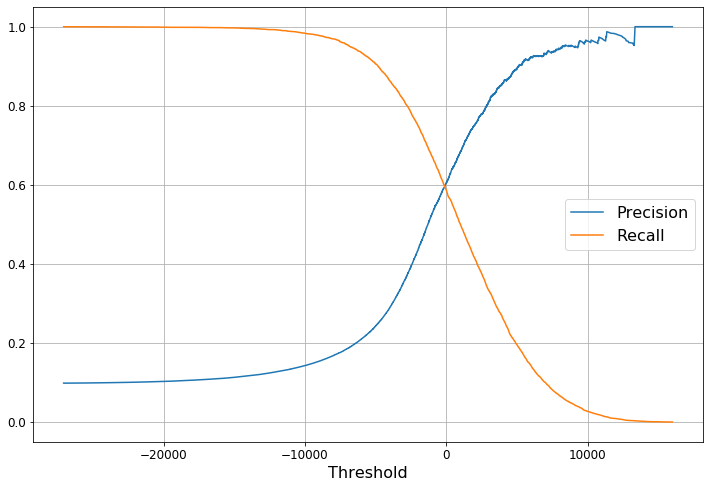

In [29]:
import seaborn as sns
def plot_precision_and_recall_vs_threshold(precisions, recalls, thresholds):
    sns.lineplot(x=thresholds, y=precisions[:-1])
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=thresholds, y=precisions[:-1], ax=ax)
sns.lineplot(x=thresholds, y=recalls[:-1], ax=ax)
plt.legend(['Precision', 'Recall'], loc="center right", fontsize=16) 
plt.xlabel("Threshold", fontsize=16)        
plt.grid(True)                                      
plt.show()

In [30]:
# Let's find the threshold for which we can achieve a 90% precision
threshold_90_prec = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_prec

5090.0629414928335

In [31]:
y_train_pred_90 = (y_scores >= threshold_90_prec)
precision_score(y_train_8, y_train_pred_90), recall_score(y_train_8, y_train_pred_90)

(0.9004854368932039, 0.19022389335156384)

Now we have reached a 90% precision, at the expense of recall, which is now 19%!

### 4.1.3 Performance Measures: The ROC curve

Another tool that can be used to evaluate a classifier performance is the receiver-operating curve. The ROC curves plots the true positive rate (TPR, i.e. recall) vs the false positive rate (FPR). 

Specificity or TNR: $$ TNR  = \frac{TN}{TN + FP} $$


False positive rate: $$FPR = 1 - TNR$$
The ROC curve plots sensitivity agains (1-specificity) 

In [32]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_8, y_scores)

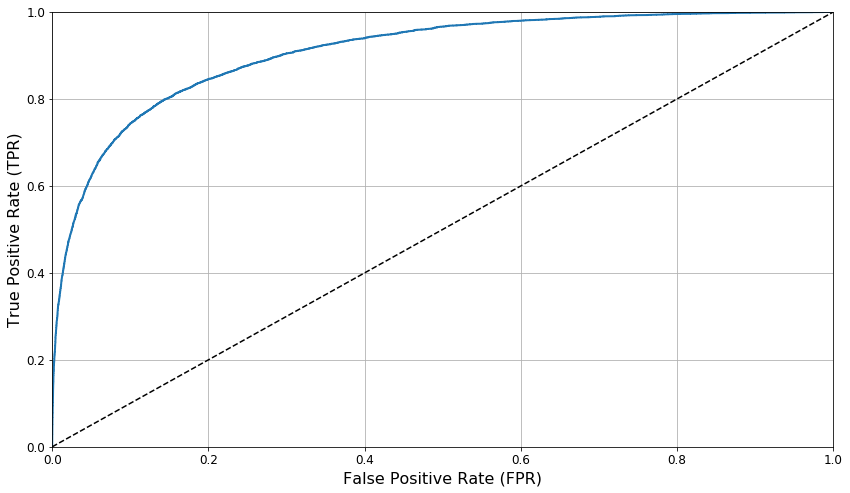

In [33]:
plt.figure(figsize=(14, 8))
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)
    plt.grid(True)
plot_roc_curve(fpr, tpr)
plt.show()


You can measure the _area under the curve_ (AUC) if you want to compare the performance of different classifiers. 

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_8, y_scores)

0.9076778308700801

As a general rule, prefer the Precision/Recall curve if the positive class is uncommon or if you worry more about the false positives rather than the false negatives. In the other scenarios, prefer the ROC curve.
Let's try two different classifiers: a Naive Bayes Classifier assuming multinomial distribution and a Random Forest classifier

In [35]:
from sklearn.naive_bayes import MultinomialNB
mnb_cl = MultinomialNB()
y_probs_mnb = cross_val_predict(mnb_cl, X_train, y_train_8, cv=3, 
                                method='predict_proba')

In [36]:
from sklearn.ensemble import RandomForestClassifier
forest_cl = RandomForestClassifier(n_estimators=100, random_state=77)
y_probs_forest = cross_val_predict(forest_cl, X_train, y_train_8, cv=3,
                                    method="predict_proba")

In [37]:
# Naive Bayes scores
y_scores_mnb = y_probs_mnb[:, 1]    # score = proba of positive class
fpr_mnb, tpr_mnb, thresholds_mnb = roc_curve(y_train_8, y_scores_mnb)
# Random Forests scores
y_scores_forest = y_probs_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_8,y_scores_forest)
# plt.plot(fpr, tpr, "b:", label="SGD")


**Exercise 4**: Use the scores computed above for `sgd_cl`, `mnb_cl`, `forest_cl` to plot out the three ROC curves on the same plot. You can use, if you wish the `plot_roc_curve()` function defined above. Afterward compute the area under the curve for `mnb_cl` and `forest_cl`. Which is the best and the worst classifier?

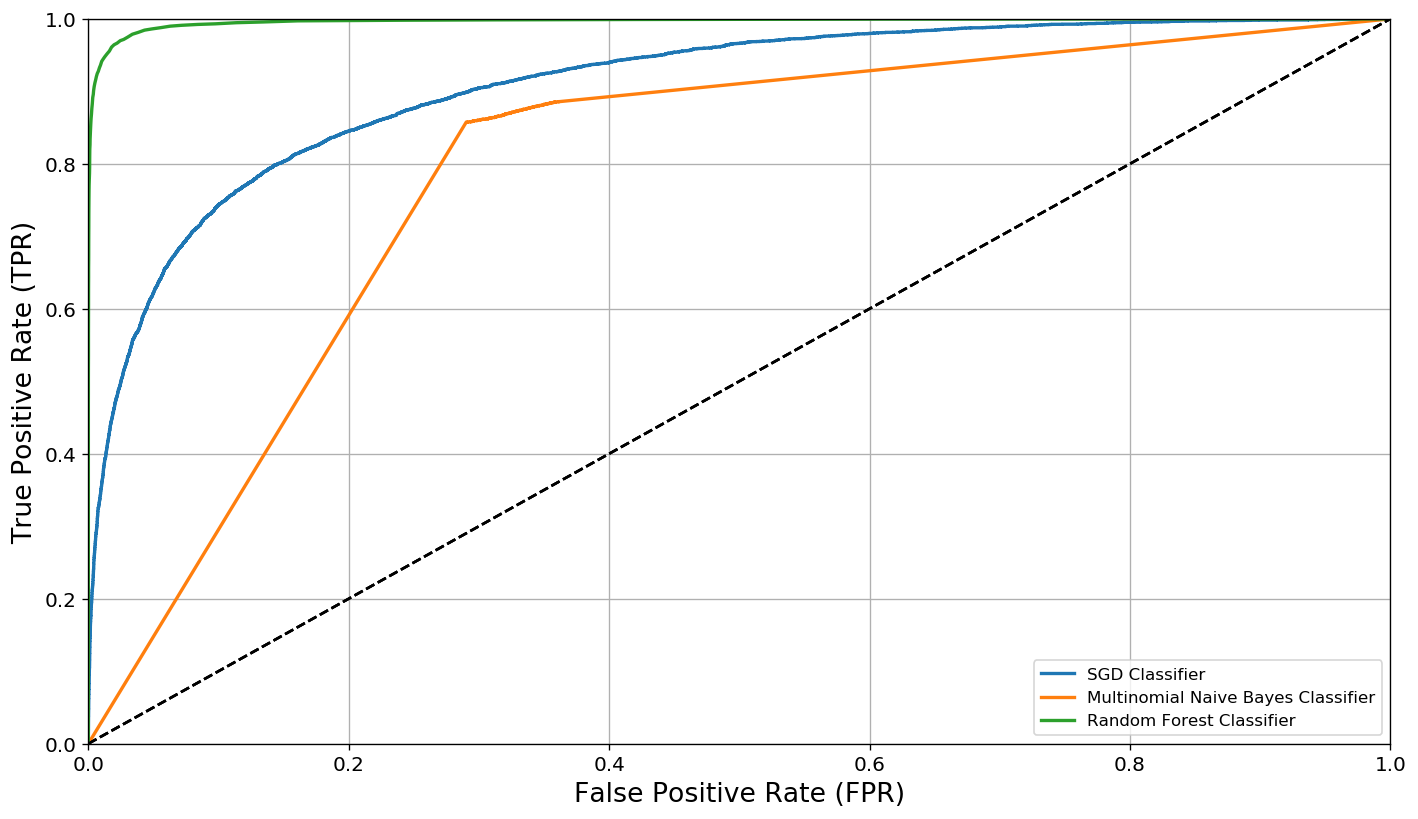

In [38]:
# Write your solution here:
plt.figure(figsize=(14, 8), dpi=120)
plot_roc_curve(fpr, tpr, "SGD Classifier")
plot_roc_curve(fpr_mnb, tpr_mnb, "Multinomial Naive Bayes Classifier")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest Classifier")
plt.legend(loc="lower right")
plt.show()

In [39]:
roc_auc_score(y_train_8, y_scores_mnb)

0.7885697938380328

In [40]:
roc_auc_score(y_train_8, y_scores_forest)

0.9963887820890495

## 4.2 Multiclass Classification

When you need to distinguish more than two classes, you have a multiclass classification problem. ML learning algorthms, solve the multiclass problem mainly in three ways:
* they support multi-class classification natively (SGD, Random Forests, Naive Bayes)
* they are binary classifiers in one-vs-the-rest strategy (OvR) ($N$ classifiers are needed for $N$ classes)
* they are binary classifiers in one-vs-one-strategy (OvO) ($N\times N-1/2$ classifiers are needed for $N$ classes). Each classifier has to be trained only on the subset of the training set for the two classes that it must distinguish.

Support Vector Machines are generally trained using the OvO approach. Let's see an example

In [41]:
from time import time
start = time()
from sklearn.svm import SVC
svm_cl = SVC(gamma='auto')
svm_cl.fit(X_train[:1000], y_train[:1000])
print('Duration: {} s'.format(time() - start))
svm_cl.predict(X_train[:10])

Duration: 1.3996777534484863 s


array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [42]:
scores = svm_cl.decision_function(X_train[:10])
scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243],
       [ 9.29838234,  7.09167958,  3.82972099,  1.79572006,  5.8885703 ,
         0.7913911 ,  2.80027801,  8.10392157, -0.22656281,  4.83753243],
       [ 3.82111996,  7.09167958,  4.83444983,  1.79943469,  9.29932174,
         0.79485736,  2.80437474,  8.10392157, -0.22417259,  5.84182891],
       [ 3.82760119,  9.29995923,  4.84239684,  1.80408497,  6.90366992,
         0.79908447,  2.80938404,  8.10392157, -0.22130643,  5.85060746],
       [ 3.81790353,  7.09167958,  4.83058232,  1.79710089,  5.8885703 ,
         0.79272692,  2.80181215,  8.10392157, -0.22565337,  9.29885985],
       [ 3.81723639,  7.09167958,  9.29871755,  1.79670336,  5.8885703 ,
         0.79230931,  2.80133228,  8.10392157, -0.22592444,  4.83753243],
       [ 3.82760119,  9.29995923,  4.84239684,  1.80408497,  6.90366992,
         0.79908447,  2.80938404,  8.10392157

In [43]:
np.argmax(scores, axis=1)

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=int64)

In [44]:
svm_cl.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [45]:
forest_cl = RandomForestClassifier(n_estimators=100, random_state=77)
cross_val_score(forest_cl, X_train, y_train, cv=3, scoring='accuracy')

array([0.96540692, 0.96279814, 0.96614492])

In [46]:
sgd_cl = SGDClassifier(random_state=77, tol=1e-3, max_iter=2000, n_jobs=-1)
cross_val_score(sgd_cl, X_train, y_train, cv=3, scoring='accuracy')

array([0.85687862, 0.86254313, 0.89338401])

Our `sgd_cl` should be initialized with a higher max_iter (eg 2000), otherwise the algorithm might not converge. This is not done in the live demo because the execution time becomes considerable.
### <span style="color:red">**NOTE: do not run this in the class, it takes way too much time.**</span>

In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
start = time()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
scores = cross_val_score(sgd_cl, X_train_scaled, y_train, cv=3, scoring='accuracy')
print('Execution time {} s'.format(time() - start))
scores

Execution time 290.379873752594 s


array([0.90311938, 0.89544477, 0.90368555])

### 4.2.1 Model Evaluation

In a proper machine learning problem solving approach you would pre-process the input data (as shown in Class 2) and then try a few ML algorithms, also exploring the parameter space using `GridSearchCV` or `RandomizedSearchCV`.
Hypothesising that you have done so, and that you have a good model, you will then want to evaluate its performance.
Let's look a the confusion matrix, as a first step.

In [48]:
# Alternative option:
sgd_cl = SGDClassifier(random_state=77, tol=1e-3, max_iter=2000, n_jobs=-1)
start = time()
y_train_pred = cross_val_predict(sgd_cl, X_train_scaled, y_train, cv=3)
c_mat = confusion_matrix(y_train, y_train_pred)
print('Execution time {} s'.format(time() - start))

Execution time 285.14920926094055 s


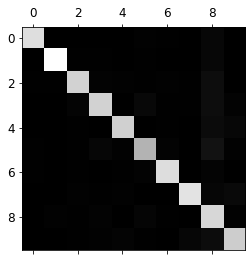

In [49]:
plt.matshow(c_mat, cmap=plt.cm.gray)
plt.show()

Let’s plot the errors. Firstly, we divide each value by the number of images in the corresponding class so that we compare error rates rather than absolute numbers of errors. Then we fill the values along the diagonal with zeros to keep only the classification errors.

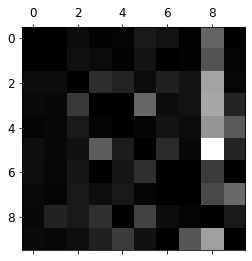

In [50]:
row_sums = c_mat.sum(axis=1, keepdims=True)
norm_c_mat = c_mat / row_sums
np.fill_diagonal(norm_c_mat, 0)
plt.matshow(norm_c_mat, cmap=plt.cm.gray)
plt.show()

Now, we can better see which type of errors our classifier makes. Which are these?

## 4.3 Multilabel and Multioutput Classification

In [51]:
from sklearn.neighbors import KNeighborsClassifier

y_train_prime = np.in1d(y_train, [2, 3, 5, 7])
y_train_odd = y_train % 2 == 1
y_multilabel = np.c_[y_train_prime, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [52]:
knn_clf.predict(X_train[:10])

array([[ True,  True],
       [False, False],
       [False, False],
       [False,  True],
       [False,  True],
       [ True, False],
       [False,  True],
       [ True,  True],
       [False,  True],
       [False, False]])

In [53]:
y_train[:10], y_multilabel[:10, 0], y_multilabel[:10, 1]

(array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8),
 array([ True, False, False, False, False,  True, False,  True, False,
        False]),
 array([ True, False, False,  True,  True, False,  True,  True,  True,
        False]))

### <span style="color:red">**NOTE: do not run this in the class, it takes way too much time.**</span>

In [54]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9809047170280953